# Stroke predictions

### Introduction

In this notebook we investigate stroke predictions. We will train various machine learning algorithms to predict occurrences of strokes for new patients. The dataset has been taken from [Kaggle](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) and was sponsored by [fedesoriano](https://www.kaggle.com/fedesoriano).

### Imports and settings

In [1]:
# Standard Python libraries:
import sys
import time
from typing import Dict, Any, Union
import warnings

# Data processing and modeling:
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Data visualization:
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous third-party libraries:
from nptyping import NDArray

# Settings:
warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize)
sns.set_theme()

### Data parsing

The variable *input_path* corresponds to the path of the input CSV file (the healtcare dataset). This file is converted to a pandas dataframe where each row corresponds to a unique patient.

In [2]:
input_path = "stroke_dataset.csv"
df = pd.read_csv(input_path)

Our dataframe contains the following columns:

In [3]:
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


The meanings of the columns are rather self-explanatory. There are eleven features in total, plus the label. The label is represented by the *stroke* column. Note that the *bmi* column has missing values, which is something that we will tackle later. Furthermore, a number of features are categorical rather than numerical. As most machine learning algorithms require numeric input, we will address this issue for each categorical feature individually.

### Data exploration and preprocessing

In the following we will study each column in more detail. Besides exploratory analyses, we will also immediately perform most of the required preprocessing.

#### ID feature

Let's start with the *id* column. Since this column will not be relevant to predict strokes, we will simply drop it. However, before we remove it let us make sure that the dataset does not contain any duplicate IDs.

In [5]:
df = df.drop_duplicates(subset="id")
df = df.drop(["id"], axis=1)

#### Gender feature

The *gender* column shows the following distribution:

In [6]:
df["gender"].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

For simplicity, we will only consider two gender options. The *Other* value can be replaced by the majority vote, which is *Female*. Furthermore, we will convert gender into a numerical variable using binary encoding:

In [7]:
df["gender"] = df["gender"].replace(["Other"], "Female")
gender_conversion = {"Male": 0, "Female": 1}
df["gender"] = df["gender"].map(gender_conversion)
df["gender"] = df["gender"].astype(int)

In the plot below we can see how gender affects the probability of getting a stroke:

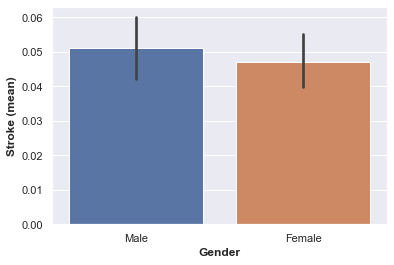

In [8]:
plt.figure(figsize=(6,4))
sns.barplot(x="gender", y="stroke", data=df)
plt.xticks(list(gender_conversion.values()), list(gender_conversion.keys()))
plt.xlabel("Gender", fontweight="bold")
plt.ylabel("Stroke (mean)", fontweight="bold")
plt.show()

The wide, colored bars represent mean values and the black lines provide the boundaries of the 95% confidence interval. We note that there is no big differene between males and females.

#### Age feature

Next up is the *age* column:

In [9]:
df["age"].describe()

count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

The correlation between age and having a stroke is as follows:

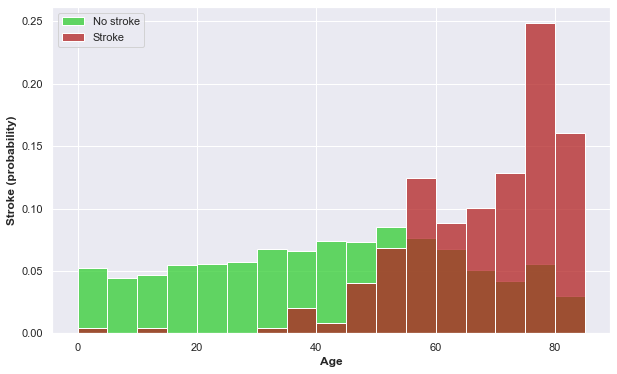

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(df[df["stroke"] == 0]["age"], binwidth=5, binrange=[0, 85], stat="probability", color="limegreen", label="No stroke")
sns.histplot(df[df["stroke"] == 1]["age"], binwidth=5, binrange=[0, 85], stat="probability", color="firebrick", label="Stroke")
plt.xlabel("Age", fontweight="bold")
plt.ylabel("Stroke (probability)", fontweight="bold")
plt.legend()
plt.show()

The sum of the bar heights for each scenario (stroke vs. no stroke) equals unity. We can infer that the chances of having a stroke significantly increase with age.

#### Hypertension feature

The *hypertension* field takes on the values 0 (no hypertension) and 1 (hypertension): 

In [11]:
df["hypertension"].value_counts()

0    4612
1     498
Name: hypertension, dtype: int64

The relation with *stroke* can be visualized as follows:

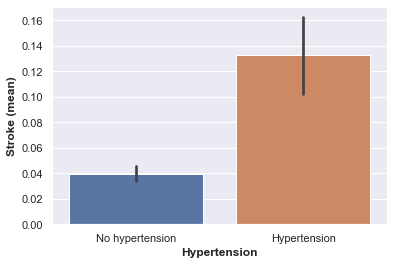

In [12]:
hypertension_conversion = {"No hypertension": 0, "Hypertension": 1}
plt.figure(figsize=(6,4))
sns.barplot(x="hypertension", y="stroke", data=df)
plt.xticks(list(hypertension_conversion.values()), list(hypertension_conversion.keys()))
plt.xlabel("Hypertension", fontweight="bold")
plt.ylabel("Stroke (mean)", fontweight="bold")
plt.show()

We note that patients with hypertension are more likely to experience a stroke.

#### Heart disease feature

The variable *heart_disease* is either 0 (no heart disease) or 1 (heart disease):

In [13]:
df["heart_disease"].value_counts()

0    4834
1     276
Name: heart_disease, dtype: int64

The plot below shows the correlation between heart disease and strokes:

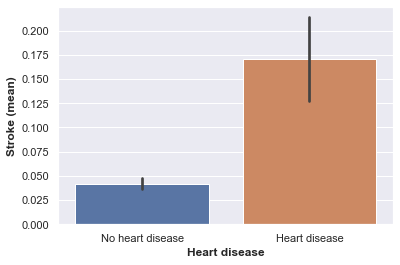

In [14]:
heart_conversion = {"No heart disease": 0, "Heart disease": 1}
plt.figure(figsize=(6,4))
sns.barplot(x="heart_disease", y="stroke", data=df)
plt.xticks(list(heart_conversion.values()), list(heart_conversion.keys()))
plt.xlabel("Heart disease", fontweight="bold")
plt.ylabel("Stroke (mean)", fontweight="bold")
plt.show()

From this plot we infer that heart disease increases the chances of experiencing a stroke.

#### Ever married feature

The column *ever_married* shows whether the patient has ever been married:

In [15]:
df["ever_married"].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

To convert this feature to a numerical one, we can apply binary encoding:

In [16]:
married_conversion = {"No": 0, "Yes": 1}
df["ever_married"] = df["ever_married"].map(married_conversion)
df["ever_married"] = df["ever_married"].astype(int)

The distribution of this variable with respect to strokes is as follows:

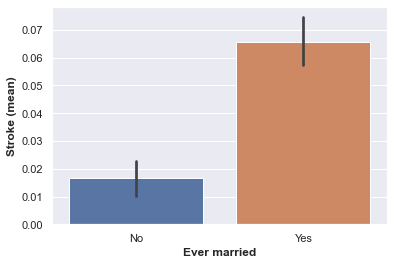

In [17]:
plt.figure(figsize=(6,4))
sns.barplot(x="ever_married", y="stroke", data=df)
plt.xticks(list(married_conversion.values()), list(married_conversion.keys()))
plt.xlabel("Ever married", fontweight="bold")
plt.ylabel("Stroke (mean)", fontweight="bold")
plt.show()

It seems that marriage significantly increases the chances of having a stroke.

#### Work type feature

Next, we have the column *work_type*. There are five possible values:

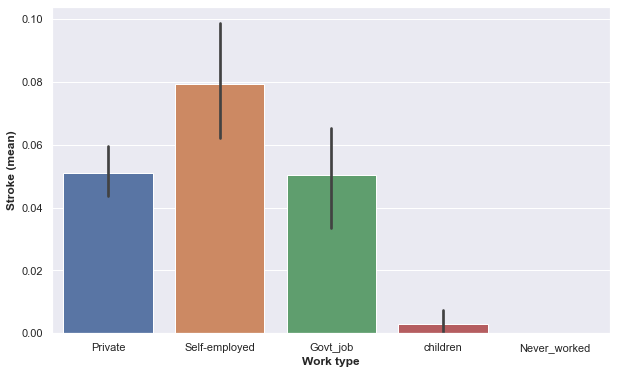

In [18]:
plt.figure(figsize=(10,6))
sns.barplot(x="work_type", y="stroke", data=df)
plt.xlabel("Work type", fontweight="bold")
plt.ylabel("Stroke (mean)", fontweight="bold")
plt.show()

Note that *Private* and *Govt_job* have a similar impact on strokes. The same is true for *children* and *Never_worked*. For this reason, we can create three categories instead without loosing much information. Moreover, the fact that a patient is a child is actually redundant as it is already captured by the *age* field.

In [19]:
df["work_type"] = df["work_type"].replace(["Self-employed"], "self-employed")
df["work_type"] = df["work_type"].replace(["Private", "Govt_job"], "employed")
df["work_type"] = df["work_type"].replace(["children", "Never_worked"], "never_employed")

# Sanity check that children (up to age 12) are never employed:
df.loc[df["age"] < 13, "work_type"] = "never_employed"

df["work_type"].value_counts()

employed          3581
self-employed      818
never_employed     711
Name: work_type, dtype: int64

Since the work type categories are nominal, we can benefit from one-hot encoding (we  will drop one column to remove redundant information) to create a numerical variable:

In [20]:
df_work_ohe = pd.get_dummies(df["work_type"], prefix="work_type", drop_first=True)
df = pd.concat([df, df_work_ohe], axis=1)
df = df.drop(["work_type"], axis=1)

#### Residence type feature

For the *residence_type* field, the distribution is as follows:

In [21]:
df["residence_type"].value_counts()

Urban    2596
Rural    2514
Name: residence_type, dtype: int64

We can convert this categorical field to a numerical one using binary encoding:

In [22]:
residence_conversion = {"Rural": 0, "Urban": 1}
df["residence_type"] = df["residence_type"].map(residence_conversion)
df["residence_type"] = df["residence_type"].astype(int)

The plot below shows the relation of this variable with *stroke*:

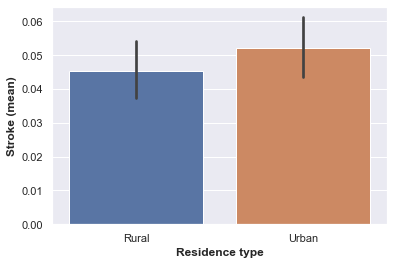

In [23]:
plt.figure(figsize=(6,4))
sns.barplot(x="residence_type", y="stroke", data=df)
plt.xticks(list(residence_conversion.values()), list(residence_conversion.keys()))
plt.xlabel("Residence type", fontweight="bold")
plt.ylabel("Stroke (mean)", fontweight="bold")
plt.show()

Residence type does seem to affect strokes much.

#### Glucose level feature

The following column, *avg_glucose_level*, describes the average glucose level in mg/dL. Its statistical details read:

In [24]:
df["avg_glucose_level"].describe()

count    5110.000000
mean      106.147677
std        45.283560
min        55.120000
25%        77.245000
50%        91.885000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64

From the [Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/diabetes/diagnosis-treatment/drc-20371451) we learn the following in relation to diabetes:

> A blood sugar level less than 140 mg/dL is normal. A reading of more than 200 mg/dL after two hours indicates diabetes. A reading between 140 and 199 mg/dL indicates prediabetes.

Glucose level and strokes are related as follows:

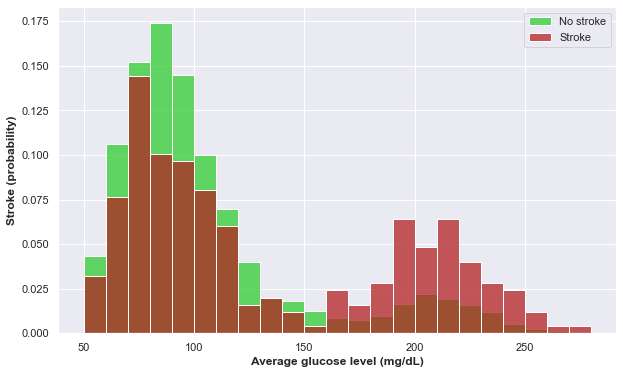

In [25]:
plt.figure(figsize=(10,6))
sns.histplot(df[df["stroke"] == 0]["avg_glucose_level"], binwidth=10, binrange=[50, 280], stat="probability", color="limegreen", label="No stroke")
sns.histplot(df[df["stroke"] == 1]["avg_glucose_level"], binwidth=10, binrange=[50, 280], stat="probability", color="firebrick", label="Stroke")
plt.xlabel("Average glucose level (mg/dL)", fontweight="bold")
plt.ylabel("Stroke (probability)", fontweight="bold")
plt.legend()
plt.show()

From the above plot we infer that there is a (positive) relation between strokes and being (pre)diabetic.

#### Smoking status feature

The next feature column is *smoking_status*. There are four possible values:

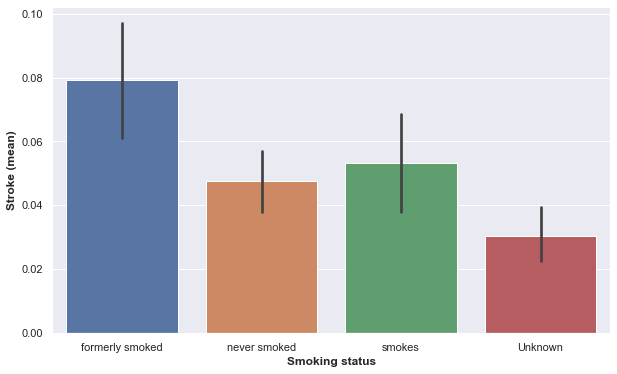

In [26]:
plt.figure(figsize=(10,6))
sns.barplot(x="smoking_status", y="stroke", data=df)
plt.xlabel("Smoking status", fontweight="bold")
plt.ylabel("Stroke (mean)", fontweight="bold")
plt.show()

Although smoking does not seem beneficial for your health, the relationship with strokes is not so clear from this plot due to the large confidence intervals.

The value *Unknown* means that information on smoking status is unavailable. To decide on what to do with this, let us look at the number of occurrences:

In [27]:
df["smoking_status"].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

Since *Unknown* occurs 1544 times in our dataset, it is best to leave it as a separate category rather than to replace it by guesses.

We consider this variable to be nominal. For that reason we can apply one-hot encoding to convert it into a numerical feature:

In [28]:
df_smoking_ohe = pd.get_dummies(df["smoking_status"], prefix="smoking_status", drop_first=True)
df = pd.concat([df, df_smoking_ohe], axis=1)
df = df.drop(["smoking_status"], axis=1)

#### BMI feature

The next column is *bmi*, the body mass index (BMI) in kg/m$^2$. Its statistical details are as follows:

In [29]:
df["bmi"].describe()

count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64

From the [CDC](https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html) we learn the following in relation to obesity:

| BMI | Weight status |
| ---: | :--- |
| < 18.5 | Underweight |
| 18.5 - 24.9 | Normal weight |
| 25.0 - 29.9 | Overweight |
| > 30.0 | Obese |

From earlier we know that there are 201 missing values for this field. There are various ways to deal with this. The best option might be to infer those missing values from the other features using a regression model. For convenience, let us pick the easiest regression algorithm for this, i.e. linear regression:

In [30]:
train_data = df.dropna()
X_train = train_data.drop("bmi", axis=1)
y_train = train_data["bmi"]

test_data = df[df["bmi"].isnull()]
X_test = test_data.drop("bmi", axis=1)

model = LinearRegression()
model.fit(X_train, y_train)
y_test = model.predict(X_test)

bmi_slice = df["bmi"].copy()
bmi_slice[np.isnan(bmi_slice)] = y_test
df["bmi"] = bmi_slice

Now that our BMI values are complete, let us study the relationship with strokes:

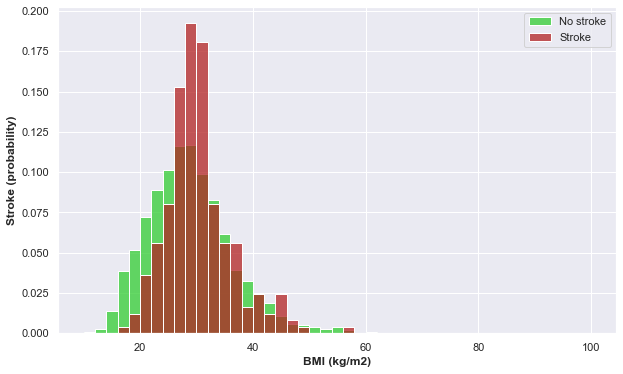

In [31]:
plt.figure(figsize=(10,6))
sns.histplot(df[df["stroke"] == 0]["bmi"], binwidth=2, binrange=[10, 100], stat="probability", color="limegreen", label="No stroke")
sns.histplot(df[df["stroke"] == 1]["bmi"], binwidth=2, binrange=[10, 100], stat="probability", color="firebrick", label="Stroke")
plt.xlabel("BMI (kg/m2)", fontweight="bold")
plt.ylabel("Stroke (probability)", fontweight="bold")
plt.legend()
plt.show()

The distributions for stroke and no stroke are fairly similar. However, strokes seem to be relatively common in the BMI range of 26-32 kg/m$^2$.

#### Stroke label

Finally, we have the target column *stroke*. Its values refer to whether the patient has experienced a stroke (1) or not (0).

In [32]:
df["stroke"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

0    95.1%
1     4.9%
Name: stroke, dtype: object

We note that this dataset is extremely imbalanced. In fact, if our model would always predict 0 it would be correct 95% of the time! For this reason, accuracy will not be a suitable metric to measure model performance. Furthermore, in the next section we will try to balance our dataset more to avoid any model bias.

#### Wrap-up

To conclude the preprocessing, let us verify that there are no longer any missing values and that all fields are numeric of nature:

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 0 to 5109
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          5110 non-null   int64  
 1   age                             5110 non-null   float64
 2   hypertension                    5110 non-null   int64  
 3   heart_disease                   5110 non-null   int64  
 4   ever_married                    5110 non-null   int64  
 5   residence_type                  5110 non-null   int64  
 6   avg_glucose_level               5110 non-null   float64
 7   bmi                             5110 non-null   float64
 8   stroke                          5110 non-null   int64  
 9   work_type_never_employed        5110 non-null   uint8  
 10  work_type_self-employed         5110 non-null   uint8  
 11  smoking_status_formerly smoked  5110 non-null   uint8  
 12  smoking_status_never smoked     51

In [34]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,residence_type,avg_glucose_level,bmi,stroke,work_type_never_employed,work_type_self-employed,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,67.0,0,1,1,1,228.69,36.600000,1,0,0,1,0,0
1,1,61.0,0,0,1,0,202.21,31.158272,1,0,1,0,1,0
2,0,80.0,0,1,1,0,105.92,32.500000,1,0,0,0,1,0
3,1,49.0,0,0,1,1,171.23,34.400000,1,0,0,0,0,1
4,1,79.0,1,0,1,0,174.12,24.000000,1,0,1,0,1,0


### Model building

Now that we have preprocessed our dataset, we can try to model it with various machine learning algorithms. The one with the highest F$_1$-score, will be picked as our final model.

First, we make a train-test split of the data:

In [35]:
X = df.drop(["stroke"], axis=1)
y = df["stroke"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Let us take a look at the distribution of the target label:

In [36]:
y_train.value_counts()

0    3648
1     184
Name: stroke, dtype: int64

Since our dataset is highly imbalanced, there is a risk that our models will be biased toward predicting no stroke. To combat this issue, we can apply an oversampling technique called SMOTE, which is short for Synthetic Minority Oversampling Technique. This technique makes use of the K-nearest neighbors algorithm to synthesize more data for the minority class. After applying SMOTE to the training set, the stroke vs. no-stroke rows are equally balanced.

In [37]:
oversampler = SMOTE(random_state=0)
X_train, y_train = oversampler.fit_resample(X_train, y_train)
y_train.value_counts()

0    3648
1    3648
Name: stroke, dtype: int64

Next, we apply standardization (zero mean and unit variance) to *X_train* and *X_test* to ensure that all data 'lives' at the same scale:

In [38]:
scaler = StandardScaler()
feature_sets = [scaler.fit_transform(feature_set) for feature_set in [X_train, X_test]]    
X_train = feature_sets[0]
X_test = feature_sets[1]

# X_train = np.array(X_train)
# X_test = np.array(X_test)

Before we start model building, it is good practice to verify the dimensions of the data:

In [39]:
y_train = np.array(y_train)
print("Dimensions of the training set:\n")
print("Features:", X_train.shape, "\nLabels:", y_train.shape)

y_test = np.array(y_test)
print("\nDimensions of the test set:\n")
print("Features:", X_test.shape, "\nLabels:", y_test.shape)

Dimensions of the training set:

Features: (7296, 13) 
Labels: (7296,)

Dimensions of the test set:

Features: (1278, 13) 
Labels: (1278,)


Using the Scikit-learn library, we can quickly try many different machine learning algorithms and select the best one. To this end, we define a function that we can invoke for each algorithm to train and study the corresponding models:

In [40]:
def train_test_model(
        name: str,
        algorithm: Any, 
        X_train: NDArray[float], 
        y_train: NDArray[int], 
        X_test: NDArray[float], 
        y_test: NDArray[int],
) -> Dict[str, Union[float, NDArray[int], str]]:
    """Trains and tests a model for a given machine learning algorithm.
    
    Args:
        name: The name of the algorithm.
        algorithm: The Scikit-learn algorithm class.
        X_train: The input for training.
        y_train: The labels for training.
        X_test: The input for testing.
        y_test: The labels for testing.
    
    Returns:
        The accuracy, precision, recall, and F1-score pertaining to the obtained model, 
        as well as the confusion matrix.
    """
    
    classifier = algorithm.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred, average="micro"), 3)
    recall = round(recall_score(y_test, y_pred, average="micro"), 3)
    f1 = round(f1_score(y_test, y_pred, average="micro"), 3)    
    conf_mat = confusion_matrix(y_test, y_pred)
    class_rep = classification_report(y_test, y_pred)
    results = {
        "Accuracy": accuracy, 
        "Precision": precision, 
        "Recall": recall, 
        "F1-score": f1, 
        "Confusion matrix": conf_mat,
        "Classification report": class_rep,
    }

    return results

We can collect all the algorithms that we want to try out in a single dictionary:

In [41]:
algorithms = {
    "Gaussian naive Bayes": GaussianNB(),
    "K-nearest neighbors": KNeighborsClassifier(),
    "Support vector machine": SVC(),
    "Logistic regression": LogisticRegression(),
    "Multilayer perceptron": MLPClassifier(solver="lbfgs", random_state=0),
    "Decision tree": DecisionTreeClassifier(random_state=0),
    "Random forest": RandomForestClassifier(random_state=0),
}

In the following we train and test models pertaining to all provided algorithms:

In [42]:
model_results = []
for name, algorithm in algorithms.items():
    start_time = time.time()
    results = train_test_model(name, algorithm, X_train, y_train, X_test, y_test)
    model_results.append((name, results["F1-score"]))
    elapsed_time = round(time.time() - start_time, 2)
    print("{}\nDuration: {} seconds\n\nConfusion matrix: \n{}\n\nClassification report: \n{}\nAccuracy: {}, Precision: {}, Recall: {}, F1-score: {}\n\n".format(name.upper(), elapsed_time, results["Confusion matrix"], results["Classification report"], results["Accuracy"], results["Precision"], results["Recall"], results["F1-score"]))

GAUSSIAN NAIVE BAYES
Duration: 0.03 seconds

Confusion matrix: 
[[1213    0]
 [  65    0]]

Classification report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1213
           1       0.00      0.00      0.00        65

    accuracy                           0.95      1278
   macro avg       0.47      0.50      0.49      1278
weighted avg       0.90      0.95      0.92      1278

Accuracy: 0.949, Precision: 0.949, Recall: 0.949, F1-score: 0.949


K-NEAREST NEIGHBORS
Duration: 0.3 seconds

Confusion matrix: 
[[976 237]
 [ 46  19]]

Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.80      0.87      1213
           1       0.07      0.29      0.12        65

    accuracy                           0.78      1278
   macro avg       0.51      0.55      0.50      1278
weighted avg       0.91      0.78      0.83      1278

Accuracy: 0.779, Precision: 0.779, Recall: 0.779, F1

Improvements: 
- Apply SMOTE to training data as explained in https://towardsdatascience.com/5-smote-techniques-for-oversampling-your-imbalance-data-b8155bdbe2b5
- Apply grid search to various algorithms
- Apply OHE to the smoking feature
- Create plot with examples in https://www.kaggle.com/siddheshera/stroke-eda-smote-9-models-90-accuracy
- Check feature importance in random forest